In [55]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

In [56]:
def load_image(path):
    image = Image.open(path)
    #plt.imshow(image)
    #plt.title("Image loaded successfully")
    return image

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()


In [57]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()
print(vgg)
modulelist = list(vgg.features.modules())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [121]:
def dd_helper(image, layer, iterations, lr):        
    
    input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
    vgg.zero_grad()
    for i in range(iterations):
        #print('Iteration: ', i)
        out = input
        for j in range(layer):
            out = modulelist[j+1](out)
        loss = out.norm() # 正規化された画像そのものを逆伝播の微分要素として代入
        loss.backward() # 逆伝播を実行
        input.data = input.data + lr * input.grad.data # あるレイヤーの発火パターンを強調する方向
    
    
    input = input.data.squeeze()
    input.transpose_(0,1)
    input.transpose_(1,2)
    #print(input) # tensor device='cuda:0'

    #print(deprocess(input))
    #input = np.clip(deprocess(input), 0, 1)
    input = torch.clamp(deprocess(input), 0, 1) # torch.clampメソッド使わないと落ちる．np.clipはダメ
    input = input.cpu() # このメソッド使わないと落ちる
    u8input = np.uint8(input*255)
    im = Image.fromarray(u8input)
    #print("------- return img end -------")
    return im

In [122]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
            
        #image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = image1.resize(size,Image.LANCZOS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        #image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = image1.resize(size,Image.LANCZOS)
        image = ImageChops.blend(image, image1, 0.6)
    #print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [131]:
sky = load_image('./hoops.jpg')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


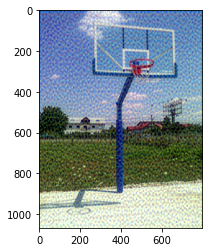

In [132]:
sky_5 = deep_dream_vgg(sky, 5, 5, 0.3, 2, 20)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


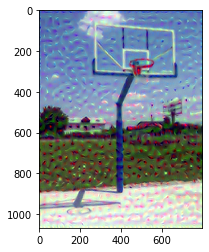

In [133]:
sky_7 = deep_dream_vgg(sky, 7, 4, 0.3, 2, 20)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


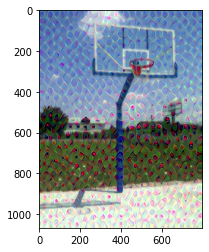

In [134]:
sky_10 = deep_dream_vgg(sky, 10, 3, 0.3, 2, 20)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


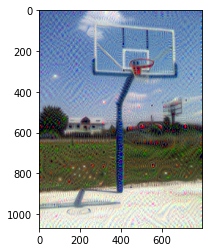

In [135]:
sky_12 = deep_dream_vgg(sky, 12, 2, 0.3, 2, 20)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


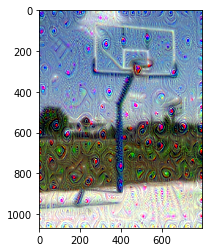

In [136]:
sky_14 = deep_dream_vgg(sky, 14, 3, 0.3, 2, 20)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


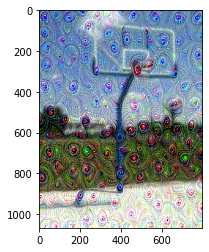

In [137]:
sky_17 = deep_dream_vgg(sky, 17, 3, 0.3, 2, 20)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


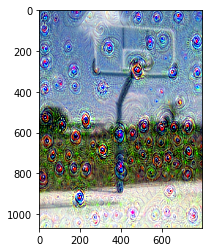

In [138]:
sky_19 = deep_dream_vgg(sky, 19, 3, 0.3, 2, 20)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


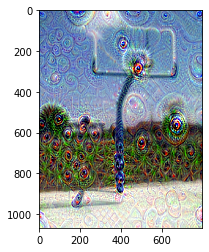

In [146]:
sky_21 = deep_dream_vgg(sky, 21, 3, 0.3, 2, 20)
sky_21.save("./result/sky21.jpg")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


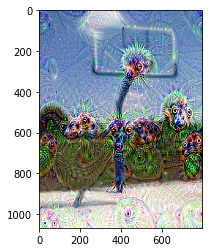

In [145]:
sky_24 = deep_dream_vgg(sky, 24, 5, 0.2, 2, 20)
sky_24.save("./result/sky24.jpg")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


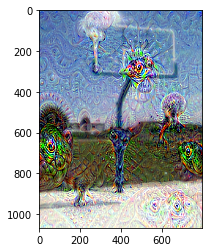

In [143]:
sky_26 = deep_dream_vgg(sky, 26, 5, 0.2, 2, 20)
sky_26.save("./result/sky26.jpg")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from ipykernel import kernelapp as app


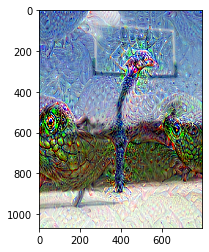

In [144]:
sky_28 = deep_dream_vgg(sky, 28, 5, 0.2, 2, 20)
sky_28.save("./result/sky28.jpg")